# 0. 라이브러리

In [1]:
!pip install tensorflow pandas matplotlib scikit-learn

In [2]:
# 공통 라이브러리 임포트
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['axes.unicode_minus'] = False # 마이너스 깨짐 방지
sns.set_style('whitegrid') # 그리드 설정

In [3]:
print("코랩 GPU 사용 가능 여부:", tf.config.list_physical_devices('GPU'))
# 출력 결과에 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 처럼 나오면 성공!
# 빈 리스트 [] 가 나오면 CPU 상태입니다.

코랩 GPU 사용 가능 여부: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# 환경에 따라 아래 셀 중 하나를 실행하세요! (여러번 실행 x, 이상하게 한글 깨지면 런타임 끊고 한번만 임포트 해주세요)

In [4]:
# [코랩]에서 맷플롯립 한글 설정
!pip install koreanize_matplotlib -q
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 37.6 MB/s eta 0:00:00


In [ ]:
# [로컬]에서 맷플롯 한글 설정
import platform

# 1. 운영체제 확인
os_name = platform.system()

# 2. 운영체제별 폰트 설정
if os_name == 'Windows':
    # 윈도우
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif os_name == 'Darwin':
    # Mac OS
    plt.rcParams['font.family'] = 'AppleGothic'
elif os_name == 'Linux':
    # 로컬 Linux (단, 'NanumGothic' 폰트가 설치되어 있어야 합니다)
    # 폰트가 없다면, 코랩에서처럼 koreanize_matplotlib 사용을 권장합니다.
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        print("Linux에 'NanumGothic' 폰트가 설치되어 있지 않습니다.")

# 1. Keras와 순환 신경망(RNN) 기초

시퀀스 데이터는 '순서'가 중요한 데이터입니다.

RNN(Recurrent Neural Network)은 이 순서를 기억하기 위해 '상태(state)'를 가지는 신경망입니다.

> 시퀀스(순차) 데이터의 큰 특징 두 가지는 무엇인가요?

답 1: 데이터를 구성하는 요소의 '순서'가 핵심적인 정보이다.

답 2: 이전 시점의 데이터가 다음 시점의 데이터에 영향을 미친다.

-> 정형 데이터와는 다른, 이러한 특징들로 인해 기존의 머신러닝 기법으로 시계열 데이터를 다루는 것은 한계가 있습니다.  
-> 과거의 정보를 기억하고, 순서의 의미를 학습할 수 있어 시퀀스 데이터 처리에 특화된 신경망이 **RNN**입니다!

> RNN이 사용하는 '세 가지 가중치'는 무엇이 있었죠?

답 1: 입력 가중치 - 현재 시점의 입력이 은닉 상태에 영향을 주는 가중치  
답 2: 순환 가중치 - 이전 시점의 은닉 상태가 현재 은닉 상태에 영향을 주는 가중치
답 3: 출력 가중치 - 현재 시점의 은닉 상태가 최종 출력에 영향을 미치는 가중치

> RNN의 핵심 원리는 무엇인가요?

답: 동일한 가중치를 시퀀스의 다양한 시점에서 반복적으로 적용하는 것.
간략히 설명: 가중치를 공유하면서 학습 파라미터 수를 줄이고, 일반화 능력을 향상시킨다.

> 기본 RNN의 세 가지 구조적 한계점과 그 설명을 간략히 작성해 주세요.

답 1: 기울기 소실
설명 1: 역전파 과정에서 반복적으로 곱해지는 기울기가 1보다 작기 때문에 기울기가 0으로 수렴하고, 먼 과거의 정보를 학습하지 못한다.
답 2: 기울기 폭주
설명 2: 반대로 역전파 과정에서 곱해지는 기울기의 크기가 1보다 크기 때문에 기울기가 무한대로 발산한다.
답 3: 느린 훈련 시간
설명 3: 계산 과정이 순차적으로 이루어져야 하므로 전체 시퀀스를 한 번에 병렬로 처리할 수 없다.


-> 이 세 가지 한계점으로 인해 RNN은 '장기 기억력 문제'를 갖게 됩니다.
### -> 중요한 정보는 오래 기억하고, 불필요한 정보는 잊는 '똑똑한' 모델이 필요하게 되겠죠!
---

### LSTM (Long Short-Term Memory)

LSTM의 핵심 아이디어는 셀 상태(Cell State)를 따로 두는 것입니다.  
LSTM은 3개의 주요 게이트를 통해 셀 상태(기억)를 관리합니다.

🗑️ Forget Gate (잊기 게이트)  

역할: 과거의 정보($C_{t-1}$) 중에서 얼마나 잊어버릴지 결정합니다.  
동작: 이전 시점의 출력($h_{t-1}$)과 현재 시점의 입력($x_t$)을 받아 0에서 1 사이의 값을 출력합니다. (1이면 완전히 기억, 0이면 완전히 잊음)  
> 예: 문장에서 주어가 바뀌면, 이전 주어에 대한 정보를 잊도록(0에 가깝게) 신호를 보냅니다

📥 Input Gate (입력 게이트)

역할: 현재 시점의 정보($x_t$) 중에서 얼마나 셀 상태에 저장할지 결정합니다.  
동작:
1. 어떤 정보를 추가할지 후보($\tilde{C}_t$)를 만듭니다. (tanh 사용)  
2. 그 후보 정보를 얼마나(비율로) 추가할지 결정합니다. (sigmoid 사용)  
> 예: 새로운 주어가 등장하면, 이 정보를 셀 상태에 추가하도록(1에 가깝게) 신호를 보냅니다.  

    > Final memory cell의 계산: $C_t$ = ( Forget Gate의 출력 $\times$ $C_{t-1}$(이전 셀 상태) ) + ( Input Gate의 출력 $\times$ $\tilde{C}_t$(새로운 후보 정보) )

📤 Output Gate (출력 게이트)

역할: 업데이트된 셀 상태($C_t$)의 정보 중에서 무엇을 현재 시점의 출력($h_t$)으로 내보낼지 결정합니다.  
동작: 셀 상태의 정보가 모두 다음 시점으로 전달될 필요는 없습니다. 현재 시점의 예측에 필요한 정보만 필터링하여 출력합니다.  


> LSTM은 별도의 '셀 상태'를 통해 장기 기억을 보존하고, 3개의 게이트를 통해 이 기억을 선택적으로 잊거나, 추가하거나, 출력합니다.  
이 구조 덕분에 **기울기가 소실되지 않고** 먼 과거까지 전달될 수 있습니다.

---
### GRU (Gated Recurrent Unit)

GRU는 LSTM의 '셀 상태'와 '은닉 상태'를 하나($h_t$)로 통합하고, 게이트도 2개로 줄였습니다.

🔄 Reset Gate (리셋 게이트)

역할: 과거 정보($h_{t-1}$)를 얼마나 무시할지 결정합니다.  
동작: 이 게이트가 0에 가까우면, 이전 시점의 상태($h_{t-1}$)를 거의 무시하고 현재 입력($x_t$)만으로 새로운 상태를 만들 준비를 합니다.
> LSTM의 'Forget Gate'와 유사하지만, 새로운 후보를 만들 때 관여합니다.

⬆️ Update Gate (업데이트 게이트)

역할: 과거 정보와 현재 정보의 갱신 비율을 결정합니다. (LSTM의 Forget 게이트와 Input 게이트를 하나로 합친 역할)  
동작:
  - 이 게이트의 값($z_t$)이 1에 가까우면: 과거 정보를 많이 무시하고, 새로운 정보($\tilde{h}_t$)를 많이 반영합니다.
  - 이 게이트의 값($z_t$)이 0에 가까우면: 새로운 정보를 무시하고, 과거 정보($h_{t-1}$)를 그대로 가져옵니다.

> GRU는 구조가 더 단순하여 LSTM보다 파라미터 수가 적고 계산 속도가 빠르면서도,  
LSTM과 비슷한, 혹은 더 좋은 성능을 보여주기도 합니다.

---
### Keras는 PyTorch에 비해 사용법이 매우 직관적입니다.

- Keras(본 과제에서 사용): model.fit(), model.compile()처럼 자주 쓰이는 기능들이 미리 정의되어 있습니다. 모델을 빠르게 학습시고, 데이터의 입력부터 출력까지의 전체 흐름을 파악하는 데 유리합니다.

- PyTorch(실습 세션에서 사용했었죠): 모델의 아주 세밀한 동작(루프, 커스터마이징, 가중치 제어 등)을 직접 구현해야 할 때가 많습니다. 이는 미세한 튜닝이나 연구 분야에서 더 강력한 유연성을 보여줍니다.<br><br>


이번 과제의 목표는 **Keras를 통해 RNN과 LSTM의 핵심 개념을 빠르게 구현하고 경험하는 것**입니다.

Keras는 `layers.SimpleRNN`, `layers.LSTM`, `layers.GRU`처럼 강력한 순환 레이어를 단 한 줄의 코드로 제공합니다.
- 예를 들어, LSTM 레이어 하나를 추가하는 것은 PyTorch에서는 여러 줄의 설정이 필요할 수 있지만, Keras에서는 단지 `layers.LSTM(64)` 한 줄이면 끝납니다.

우리는 이 '블록'들을 가져와서 실제 시퀀스 데이터(텍스트, 시계열 등)에 어떻게 적용하는지 그 흐름을 파악하는 데 집중할 것입니다.

'Keras로 RNN/LSTM을 사용하니 (비교적) 간단하게 시퀀스 모델이 만들어지는구나!' 하는 경험과 직관을 얻어가는 시간으로 생각하고, 즐겁게 코드를 채워주세요!

> 기본 Keras RNN 레이어 사용법

In [5]:
# Keras로 만드는 LSTM 레이어 예시
# Keras의 RNN 레이어는 (batch_size, timesteps, features) 형태의 입력을 기대합니다.

# 가상의 시퀀스 데이터 생성
# 예: 32개의 문장(batch_size), 각 문장은 10개의 단어(timesteps), 각 단어는 8차원의 벡터(features)
input_shape = (10, 8)
dummy_input = np.random.rand(32, *input_shape)

# LSTM 레이어 생성 (64개의 유닛)
lstm_layer = layers.LSTM(64)
output = lstm_layer(dummy_input)

print(f"입력 크기: {dummy_input.shape}")
print(f"LSTM 출력 크기: {output.shape}") # 마지막 타임스텝의 출력만 반환

# return_sequences=True: 모든 타임스텝의 출력을 반환 (RNN을 층층이 쌓을 때 필요)
lstm_layer_seq = layers.LSTM(64, return_sequences=True)
output_seq = lstm_layer_seq(dummy_input)
print(f"LSTM (seq=True) 출력 크기: {output_seq.shape}")

입력 크기: (32, 10, 8)
LSTM 출력 크기: (32, 64)
LSTM (seq=True) 출력 크기: (32, 10, 64)


---
# 2. LSTM 텍스트 감성 분석 (IMDB 리뷰 분류)

가장 고전적인 NLP(자연어 처리) 과제 중 하나입니다. 영화 리뷰 텍스트를 보고 긍정/부정을 분류합니다.

이 과제는 텍스트를 딥러닝으로 처리하는 가장 표준적인 두 가지 기술을 배웁니다.

**1. Embedding (임베딩) 레이어**  
- 왜 필요할까요?  
컴퓨터는 'good', 'bad' 같은 텍스트 단어를 직접 이해할 수 없습니다. 모든 것을 숫자로 바꿔주어야 합니다.

- 어떻게 작동하나요?  
  a. 단어를 숫자로 매핑: Embedding 레이어는 데이터에 있는 고유한 단어들 각각에 고유한 번호(인덱스)를 부여합니다.  
  b. 숫자를 '벡터'로 변환: 그 다음, 이 번호(인덱스)를 **Dense Vector**로 변환합니다. (예: 128차원의 숫자 배열)  
  > good (단어) ➔ 5 (인덱스) ➔ [0.1, 0.5, -0.2, ... , 0.9] (128차원 벡터)

  c. '의미'를 학습: 이 벡터는 단순한 ID가 아닙니다. 모델이 훈련하는 과정에서 단어의 '의미'를 학습합니다. 그 결과, 'good'과 'great', 'fantastic'은 벡터 공간에서 서로 '가까운' 위치에, 'good'과 'terrible', 'awful' 같은 단어들은 '먼' 위치에 자리 잡게 됩니다.

> 즉, Embedding은 텍스트를 컴퓨터가 이해할 수 있는 '의미가 담긴' 숫자 벡터로 바꿔주는 필수적인 첫 단계입니다.

<br><br>
**2. Bidirectional LSTM (양방향 LSTM)**  
- 왜 그냥 LSTM이 아니라 '양방향'을 쓸까요?  
RNN과 LSTM은 텍스트와 같은 시퀀스 데이터를, 앞에서부터(왼쪽에서 오른쪽으로) 차례대로 읽으며 '기억'(Context)을 쌓아갑니다.

  **하지만 문장의 진짜 의미는 뒤에 나오는 단어에 의해 결정될 때가 많습니다.**

  예시 1: "This movie was not bad at all."

  "bad"만 보면 부정적이지만, 앞에 "not"이 있습니다.

  예시 2: "The visual effects were stunning, but the story was terrible."

  "stunning" 때문에 긍정으로 판단하다가, 마지막 "terrible"을 보고 부정으로 결론 내려야 합니다.

- 어떻게 작동하나요?  
Bidirectional 래퍼(Wrapper)는 LSTM 레이어를 두 개 만듭니다.

  - 정방향 (Forward) LSTM: 텍스트를 "I loved this movie" 순서 (앞 -> 뒤)로 읽습니다.

  - 역방향 (Backward) LSTM: 텍스트를 "movie this loved I" 순서 (뒤 -> 앞)로 읽습니다.

  모델은 이 두 방향의 '기억(출력)'을 모두 합쳐서 최종 결정을 내립니다.

> 그 결과, 모델은 각 단어의 '앞뒤 문맥'을 완벽하게 파악할 수 있게 되어, 훨씬 더 정확하게 긍정/부정을 분류할 수 있습니다.

In [6]:
# 1. 데이터 로드 및 전처리
max_features = 20000  # [Vocabulary Size] 사용할 빈도수 상위 단어의 개수. 너무 크면 희소성 문제가, 너무 작으면 정보 손실이 발생할 수 있습니다.
maxlen = 200          # [Sequence Length] 각 리뷰의 최대 길이. 이보다 길면 자르고(truncating), 짧으면 0으로 채웁니다(padding).

(X_train, y_train), (X_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features
)
print(f"{len(X_train)} 훈련 시퀀스, {len(X_val)} 검증 시퀀스")

# 시퀀스 길이를 맞추기 (Padding)
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_val = keras.preprocessing.sequence.pad_sequences(X_val, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
25000 훈련 시퀀스, 25000 검증 시퀀스


In [8]:
# 2. 모델 구축 (Bidirectional LSTM)
embedding_dim = 128  # [Vector Size] 임베딩 할 때 각 단어를 몇 차원의 벡터로 표현할지 결정합니다. 보통 50~300 사이를 많이 사용합니다.
lstm_units = 64      # [Model Capacity] LSTM 셀 내부의 은닉 상태 벡터 크기입니다. 클수록 더 복잡한 패턴을 학습할 수 있지만, 과적합 위험도 커집니다.

# Input 레이어
inputs = keras.Input(shape=(None,), dtype="int32")

 # Embedding 레이어: 단어를 고차원의 벡터로 변환합니다. (예: 'good' -> [0.1, 0.5, -0.2, ...])
x = layers.Embedding(max_features, embedding_dim)(inputs)

# Bidirectional 적용: RNN이 정방향과 역방향의 텍스트를 모두 읽습니다.
x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x) # return_sequences=True: 모든 타임스텝의 출력을 반환하는 설정입니다.
x = layers.Bidirectional(layers.LSTM(lstm_units))(x)

# Dense: 출력 레이어
outputs = layers.Dense(1, activation='sigmoid')(x) # 긍정적 리뷰(1)/부정적 리뷰(0) 이진 분류를 하기 때문에 필요합니다.
                                             # 힌트: 교육세션의 [로지스틱 회귀]에서 배웠던 활성화 함수입니다!

# my_model = keras.Model(inputs(인풋 레이어), outputs(출력 레이어))
model_imdb = keras.Model(inputs, outputs)
model_imdb.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 128)      │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,757,761 (10.52 MB)

 Trainable params: 2,757,761 (10.52 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 3. 모델 컴파일 및 학습 (이 부분은 좀 오래 걸립니다)
model_imdb.compile(optimizer='Adam', # 힌트: RMSProp에 모멘텀이 합쳐진 옵티마이저!
                   loss="binary_crossentropy", # 이진 분류 문제에서는 손실 함수로 "binary_crossentropy"를 사용합니다.
                   metrics=["accuracy"])       # 모델의 성능을 평가하는 데 사용되는 척도를 metrics 파라미터에 지정합니다.

# 트레인 셋을 학습시켜 봅시다.
imdb_fit = model_imdb.fit(X_train, y_train, batch_size=128, epochs=3, validation_data=(X_val, y_val))
# 힌트: 문제집을 '몇 번' 풀 지 정하는 파라미터

Epoch 1/3
196/196 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.7072 - loss: 0.5171 - val_accuracy: 0.8737 - val_loss: 0.2990
Epoch 2/3
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9305 - loss: 0.1953 - val_accuracy: 0.8696 - val_loss: 0.3417
Epoch 3/3
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.9651 - loss: 0.1017 - val_accuracy: 0.8586 - val_loss: 0.4197


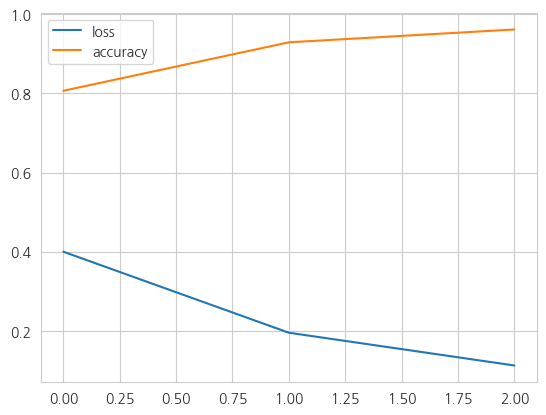

In [10]:
# 모델의 훈련 과정(loss, accuracy)을 'history' 객체를 사용하여 시각화해보세요.
plt.plot(imdb_fit.history['loss'], label='loss')
plt.plot(imdb_fit.history['accuracy'], label='accuracy')
plt.legend()

plt.show()

Bidirectional LSTM을 통해 감성 분석 모델을 학습시켰습니다.  
그럼 이 모델로 직접 영어로 영화리뷰를 작성한 뒤 긍정/부정을 예측해 볼까요?

In [11]:
# 1. IMDB 데이터셋의 '단어-인덱스' 딕셔너리 로드
# (각 단어가 어떤 숫자에 매핑되었는지 정보가 필요합니다)
word_index = keras.datasets.imdb.get_word_index()

# 2. Keras의 예약 인덱스를 맞춰주기 위한 offset
# (0: 패딩, 1: 문장 시작, 2: 모르는 단어)
offset = 3
word_index = {k:(v+offset) for k,v in word_index.items()}
word_index["<pad>"] = 0
word_index["<start>"] = 1
word_index["<unk>"] = 2

# 3. 문장을 -> 숫자 시퀀스로 변환하는 함수
def preprocess_text(text):
    # 텍스트를 소문자로 바꾸고 단어 단위로 분리 (간단한 토큰화)
    tokens = text.lower().split()

    # 단어를 인덱스로 변환 (word_index에 없으면 2 ('<unk>')로 처리)
    sequence = [word_index.get(word, 2) for word in tokens]

    # 20000 ('max_features')보다 큰 인덱스는 모르는 단어로 처리 (2)
    sequence = [idx if idx < max_features else 2 for idx in sequence]
    return sequence

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# 4. 예측해 볼 새로운 테스트 문장
test_sentence = "This is not appropriate for the child, especially under primar yschool" # 영어로 된 리뷰를 작성해 보세요!
# 예: "I loved this movie, it was fantastic and really great!""
# test_sentence = "This movie was terrible, I hated it." # 시간 남으면 부정적인 문장도 테스트해보세요

In [13]:
# 5. 문장 전처리 및 패딩
tokenized_sentence = preprocess_text(test_sentence)
# (1, maxlen=200) 형태로 만들기 (1개의 샘플)
padded_sentence = keras.preprocessing.sequence.pad_sequences([tokenized_sentence], maxlen=maxlen)

print(f"원본 문장: {test_sentence}")
print(f"변환된 시퀀스 (일부): {tokenized_sentence[:10]}...")
print(f"패딩된 시퀀스 shape: {padded_sentence.shape}")

# 6. 모델로 예측!
prediction = model_imdb.predict(padded_sentence)
score = prediction[0][0]

print(f"\n--- 예측 결과 ---")
print(f"예측 점수 (Sigmoid): {score:.4f}")

if score > 0.5:
    print(f"결과: 긍정적인 리뷰입니다. ({score*100:.2f}%)")
else:
    print(f"결과: 부정적인 리뷰입니다. ({(1-score)*100:.2f}%)")

원본 문장: This is not appropriate for the child, especially under primar yschool
변환된 시퀀스 (일부): [14, 9, 24, 2316, 18, 4, 2, 262, 467, 2]...
패딩된 시퀀스 shape: (1, 200)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step

--- 예측 결과 ---
예측 점수 (Sigmoid): 0.8634
결과: 긍정적인 리뷰입니다. (86.34%)


---
# 3. LSTM 시계열 기온 예측

이 과제는 독일 예나(Jena) 지역의 날씨 데이터셋을 사용합니다. 이 데이터에는 14개의 다양한 기상 피쳐(온도, 기압, 습도, 풍향 등)이 포함되어 있습니다.  
과거 5일간의 모든 기상 데이터(14개의 feature)를 보고, 6시간 뒤의 기온(종속변수)을 예측하는 모델을 만듭니다.

이것을 "다변량(Multivariate)" 예측이라고 부릅니다.

- 단변량 예측 (Univariate): "과거의 온도(1개)" ➔ "미래의 온도(1개)"

- 다변량 예측 (Multivariate) (지금 하려는 것): "과거의 [온도, 기압, 습도... (14개)]" ➔ "미래의 온도(1개)"

3-1. 데이터 로드

In [15]:
# 1. 데이터 로드
file_path = 'jena_climate_2009_2016.csv' # 경로 입력
df = pd.read_csv(file_path)

# 2. 데이터 확인 (14개의 특징(feature) + 날짜)
# 'p (mbar)' (기압), 'T (degC)' (온도), 'wv (m/s)' (풍속) 등...
print(df.shape)
print(df.head())

# 3. 'Date Time' 컬럼을 datetime으로 포맷팅하고, 인덱스로 설정
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.set_index('Date Time', inplace=True)

# 4. 이 데이터셋은 10분 간격으로 수집된 것입니다. 매 6번째 데이터(1시간 간격)만 샘플링합니다.
df = df[::6]
print(df.shape)
df.head()

(420551, 15)
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75     

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
2009-01-01 02:10:00,996.63,-8.85,264.57,-9.70,93.5,3.12,2.92,0.20,1.82,2.93,1312.11,0.16,0.50,158.3
2009-01-01 03:10:00,996.87,-8.84,264.56,-9.69,93.5,3.13,2.92,0.20,1.83,2.93,1312.37,0.07,0.25,129.3
2009-01-01 04:10:00,997.05,-9.23,264.15,-10.25,92.2,3.03,2.79,0.24,1.74,2.80,1314.62,0.10,0.38,203.9


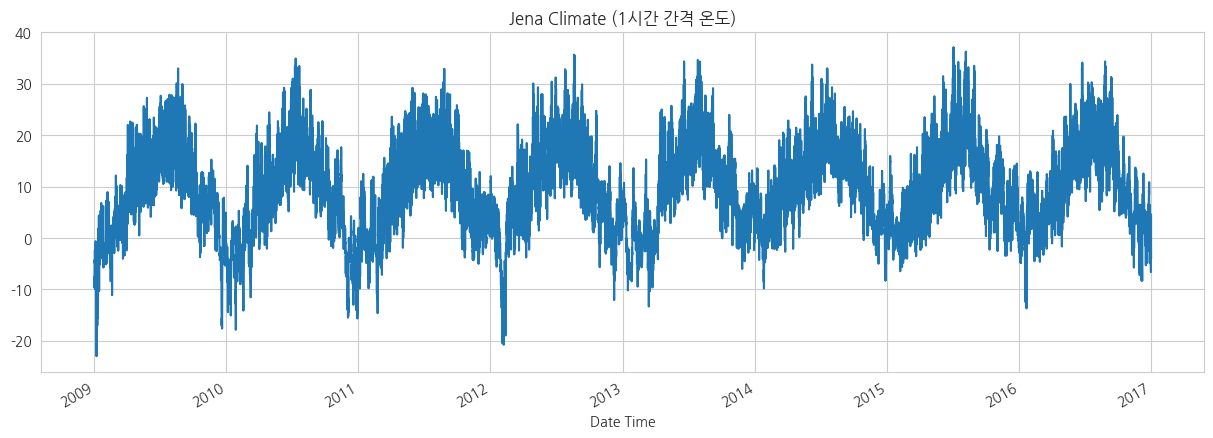

In [16]:
# 5. 온도 데이터 시각화
df['T (degC)'].plot(figsize=(15, 5))
plt.title("Jena Climate (1시간 간격 온도)")
plt.show()

3-2. 훈련 / 검증 / 테스트 데이터 분리  
시계열 데이터는 순서가 중요하므로, Train Set과 Test Set을 만들 때는 데이터를 정렬된 상태에서 그냥 싹둑 자릅니다.  
기존에 쓰던 Cross-Sectional 데이터처럼 랜덤 난수로 분리하지 않습니다.

In [17]:
# 1. 사용할 피쳐와 종속변수(타겟) 정의
# 14개의 특징 중 일부만 사용할 수도 있습니다. (이번에는 모두 사용)
X = df.drop('T (degC)', axis=1) # 온도 column을 제외한 나머지
y = df['T (degC)'] # 온도를 예측

In [18]:
# 2. 데이터 분리 (순서대로 자르기)
# 70% 훈련, 20% 검증, 10% 테스트 만큼 사용할 것입니다.
# [훈련 데이터]의 분량입니다.
split_fraction = 0.7
# [훈련 데이터+검증 데이터]의 분량입니다.
val_split_fraction = 0.9 # 힌트: 70% + 20%

# 이후에 슬라이싱을 위해 (전체 길이 정수)X(퍼센트)의 정수형으로 바꿔줄게요.
n = len(df)
train_split = int(n * split_fraction)
val_split = int(n * val_split_fraction)

In [19]:
# 3. 데이터 정규화
# 훈련 셋(train_data)의 평균과 표준편차로 모든 데이터를 정규화합니다.
# (검증/테스트 데이터의 정보가 훈련 과정에 누수되는 것을 막기 위함)
train_mean = X.iloc[:train_split].mean(axis=0)
train_std = X.iloc[:train_split].std(axis=0)

# 정규화된 피쳐 생성
X_features_normalized = (X - train_mean) / train_std

# DataFrame -> Numpy array로 변환
X_features_data = X_features_normalized.values
y_data = y.values

In [20]:
# 4. 최종 데이터 분리 (Numpy array)
X_train = X_features_data[:train_split]
y_train = y_data[:train_split]

X_val = X_features_data[train_split:val_split]
y_val = y_data[train_split:val_split]

X_test = X_features_data[val_split:]
y_test = y_data[val_split:]

print(f"x_train shape: {X_train.shape}") # (샘플 수, 13개 피쳐)
print(f"y_train shape: {y_train.shape}")   # (샘플 수,)

x_train shape: (49064, 13)
y_train shape: (49064,)


3-3. 데이터 윈도잉 (Windowing) - Keras 유틸리티 사용  
Keras는 시계열 윈도잉을 위한 `timeseries_dataset_from_array`라는 강력한 유틸리티를 제공합니다.

> 우리의 목표<br>  
입력 (X): 과거 5일 (120시간) 동안의 데이터 (sequence_length=120)  
타겟 (Y): 입력 시퀀스가 끝난 시점으로부터 6시간 뒤의 기온 (delay=6)

In [21]:
# 1. 윈도우 하이퍼파라미터 정의
# (1) 입력 시퀀스 길이 (과거를 얼마나 볼 것인가?)
sequence_length = 120 # 120시간 = 5일치 데이터를 보고 미래를 예측하겠다는 의미입니다.

# (2) 예측 지점 (미래 얼마 뒤를 예측할 것인가?)
# 현재 시점으로부터 6스텝(약 6시간) 뒤의 온도를 (예측의) 타겟으로 설정합니다.
delay = 6

# (3) 배치 크기
# 시계열 데이터는 많기 때문에(LSTM 시계열을 할 때는 데이터 양 자체가 많으면 좋아요) 보통 256, 512 등 크게 잡습니다.
batch_size = 256

#슬라이싱으로 6시간의 딜레이를 직접 만들어주는 작업
X_train_delayed = X_train[:-delay]
y_train_delayed = y_train[delay:]
# val set에도 똑같이 슬라이싱을 해줍니다.
X_val_delayed = X_val[:-delay]
y_val_delayed = y_val[delay:]

In [22]:
# 2. Keras 윈도우 생성 유틸리티 사용
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=X_train_delayed,    # 딜레이 적용된 셋을 써야 합니다.
    targets=y_train_delayed, # 타겟에도 딜레이 적용된 셋을 써야 합니다.
    sequence_length=sequence_length,
    sampling_rate=1,
    sequence_stride=1, # 샘플링 간격 (얼마나 촘촘히 볼 것인가?) # sequence_stride=1: 1시간 간격을 모두 봅니다.  sequence_stride=6: 6시간 간격으로 봅니다.
    batch_size=batch_size,
    shuffle=True # 트레인 셋이므로 윈도우 순서를 섞음
)

# 3. 검증 데이터셋 (shuffle=False)
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=X_val_delayed,    # 똑같이 딜레이 적용된 셋을 써야 합니다.
    targets=y_val_delayed, # 똑같이 딜레이 적용된 셋을 써야 합니다.
    sequence_length=sequence_length,
    sampling_rate=1,
    sequence_stride=1,
    batch_size=batch_size,
    shuffle=False # 검증 셋은 윈도우 순서를 섞지 않음
)

In [23]:
# 4. 생성된 윈도우의 Shape 확인
for batch in train_dataset.take(1):
    inputs, targets = batch
    print(f"Input shape (X): {inputs.shape}")   # (Batch, 120, 13) -> (배치, 시퀀스 길이, 피쳐 수)
    print(f"Target shape (y): {targets.shape}") # (Batch,) -> (배치,)

Input shape (X): (256, 120, 13)
Target shape (y): (256,)



3-4. LSTM 모델 구축 및 학습  
이제 (120, 13) 형태의 입력을 받아 (1,) 형태의 출력을 내보내는 모델을 만듭니다.  
여기서는 추가로 EarlyStopping이라는 툴을 써 볼게요.

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
# 1. 모델 구축 (LSTM 사용)
inputs = keras.Input(shape=(sequence_length, X_train.shape[-1])) # (120, 13)

# GRU(32) 또는 LSTM(32) 레이어를 사용하세요.
# 시퀀스의 마지막 출력만 필요하므로, [return_sequences=False]로 설정하겠습니다. (기본값이 False 입니다.)
x = layers.LSTM(32, activation='tanh', return_sequences=False)(inputs)

# Dropout 레이어: 과적합 방지
x = layers.Dropout(0.2)(x)
# 0.2는 Dropout rate로, 학습 시 랜덤하게 전체 뉴런의 20%를 꺼서 과적합을 방지합니다.

# 출력층 (Dense)
# 6시간 뒤의 '온도' 1개만 예측하면 되므로 units=1
# 온도 그 자체를 예측하는 회귀 문제이기 때문에, 활성화 함수를 넣지 않습니다
outputs = layers.Dense(1)(x)

model_lstm = keras.Model(inputs, outputs)

In [26]:
# 2. 모델 컴파일 ('회귀' 문제)
# 손실(Loss): Mean Squared Error (평균 제곱 오차)
# 지표(Metric): Mean Absolute Error (평균 절대 오차)
model_lstm.compile(optimizer='adam',
                   loss='mean_squared_error',        # 힌트: 손실함수를 지정하는 파라미터
                   metrics=['mean_absolute_error']) # 모델의 성능 평가 지표를 지정하는 파라미터

model_lstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 120, 13)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,921 (23.13 KB)

 Trainable params: 5,921 (23.13 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# 과적합을 막기 위한 EarlyStopping 객체
# val_loss가 더 이상 좋아지지 않고 몇 번 연속으로 나빠지면, 100번을 다 채우기 전에 훈련을 "조기 종료" 하는 과적합 방지 기법입니다.

early_stopping_callback = EarlyStopping(
    monitor='val_loss', # 'monitor' : 어떤 지표를 감시하면서 멈출지?
    patience=10,        # 'patience' : 몇 epoch 동안 점수가 나아지지 않으면 멈출지?
    restore_best_weights=True # 'restore_best_weights'=True : 훈련이 멈췄을 때, 가장 좋았던 시점의 가중치로 복원한다는 뜻입니다.
)

In [28]:
# 3. 모델 학습 (좀 더 오래 걸립니다)
history = model_lstm.fit(
    train_dataset,        # 2. Keras 윈도우 생성 유틸리티 사용에서 만든 train_dataset을 그대로 넣을 수 있습니다.
    epochs=100,           # 일단 100 epoch를 돌립니다. 하지만 earlystopping 기준에 걸리면 100번 전에 멈출 것입니다.
    validation_data=val_dataset, # 2. Keras 윈도우 생성 유틸리티 사용에서 만든 val_dataset
    callbacks=[early_stopping_callback]
)

Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 103.9796 - mean_absolute_error: 8.1449 - val_loss: 37.8915 - val_mean_absolute_error: 4.7488
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 37.5187 - mean_absolute_error: 4.7684 - val_loss: 28.7645 - val_mean_absolute_error: 4.1235
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 29.3426 - mean_absolute_error: 4.2208 - val_loss: 23.0889 - val_mean_absolute_error: 3.6738
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 25.1244 - mean_absolute_error: 3.9134 - val_loss: 21.7617 - val_mean_absolute_error: 3.6152
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 23.7651 - mean_absolute_error: 3.8271 - val_loss: 20.1690 - val_mean_absolute_error: 3.4697
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 22.4514 - mean_absolute_error: 3.6918 - val_loss: 22.4427 - val_mean_absolute_error: 3.6894
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 23.0582 - 

저는 Epoch 73에서 멈췄네요!

3-5. 결과 시각화  
학습된 모델의 val_mae (검증 데이터의 MAE)를 확인하고, 학습 곡선을 그립니다.

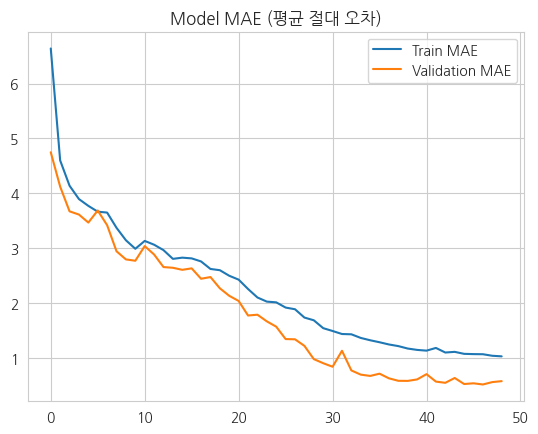

최종 검증 MAE: 0.5833 (degC)


In [29]:
# 1. 학습 과정 시각화 (MAE)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model MAE (평균 절대 오차)')
plt.legend()
plt.show()

# 2. 결과 분석
print(f"최종 검증 MAE: {history.history['val_mean_absolute_error'][-1]:.4f} (degC)")

In [30]:
# 테스트 셋에도 적용해 봅시다!

# 테스트 셋에도 딜레이(6시간)를 슬라이싱으로 적용합니다.
X_test_delayed = X_test[:-delay]
y_test_delayed = y_test[delay:]

# --- 'test_dataset'생성 ---
# val_dataset과 동일한 방식으로 만들되, 'shuffle=False'가 매우 중요합니다!
# (순서가 섞이면 실제값과 예측값을 그래프로 비교할 수 없습니다)
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=X_test, # 딜레이 적용된 X_test
    targets=y_test, # 딜레이 적용된 y_test
    sequence_length=sequence_length,
    sampling_rate=1,
    sequence_stride=1,
    batch_size=batch_size,   # (val_dataset과 동일한 배치 크기)
    shuffle=True
)

In [34]:
# 테스트 셋을 통해 예측한 y_pred를 설정합니다.
y_pred = model_lstm.predict(test_dataset)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


In [35]:
y_actual = []
# test_dataset을 순회하며 실제 y값을 리스트에 추가하고
for x_batch, y_batch in test_dataset:
    y_actual.append(y_batch.numpy())

# 리스트를 하나의 Numpy 배열로 합칩니다.
y_actual = np.concatenate(y_actual)

In [36]:
y_pred.shape # (n,1)의 2차원 형태이므로, 플롯을 그리려면 .flatten()으로 1차원으로 만들어야 합니다.

(6891, 1)

In [37]:
y_pred = y_pred.flatten()
y_pred.shape # 차원이 줄었네요.

(6891,)

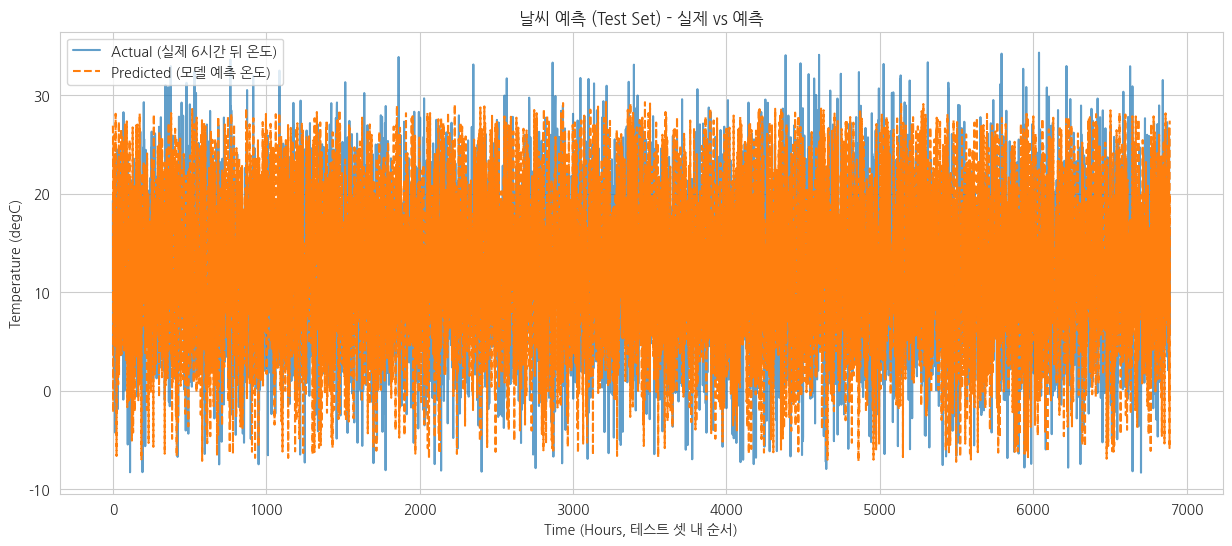

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.9648 - mean_absolute_error: 1.3369
Test MSE: 2.9853
Test MAE: 평균 1.3368도 차이


In [38]:
from matplotlib.lines import lineStyles
# --- y_test와 비교 그래프 그리기 ---

plt.figure(figsize=(15, 6))
plt.plot(y_actual, label='Actual (실제 6시간 뒤 온도)', alpha=0.7)
plt.plot(y_pred, label='Predicted (모델 예측 온도)', linestyle='--')
plt.title('날씨 예측 (Test Set) - 실제 vs 예측')
plt.xlabel('Time (Hours, 테스트 셋 내 순서)')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.show()

# 평가 지표로 비교
test_loss, test_mae = model_lstm.evaluate(test_dataset)
print(f"Test MSE: {test_loss:.4f}")
print(f"Test MAE: 평균 {test_mae:.4f}도 차이")

---
# 4. 간단한 Character-Level Seq2Seq 모델 예제

Seq2Seq(Sequence-to-Sequence) 모델은 '하나의 시퀀스'를 입력받아 '다른 시퀀스'를 출력하는 모델 구조를 말합니다.  
Seq2Seq 모델의 핵심은 **인코더와 디코더**였죠!  

우리가 하려는 "hello" ➔ "HELLO" 변환도, "영어 문장" ➔ "프랑스어 문장" 기계 번역도 모두 Seq2Seq 모델입니다.

이 과제에서는 문자 단위(Character-Level)로 이 구조를 경험해 봅니다.

**1. 인코더 (Encoder): 문장 압축기 🧠**  
인코더의 역할은 입력 문장("hello")의 모든 정보를 하나의 벡터로 압축하는 것입니다.

- 어떻게 작동할까요?  
  a. LSTM 레이어가 입력 문장을 한 글자씩 순서대로 읽습니다. ('h' ➔ 'e' ➔ 'l' ➔ 'l' ➔ 'o')  
  b. 모든 글자를 다 읽고 나면, LSTM은 이 문장의 모든 '문맥'을 담은 **최종 상태**(State)를 출력합니다. (Keras에서는 state_h, state_c로 나옵니다.)

> 이 최종 상태를 **컨텍스트 벡터**(Context Vector)라고 부릅니다. "hello"라는 단어의 의미가 이 벡터 안에 압축되어 담겨있습니다.

> **인코더는 중간 출력물은 버리고, 오직 이 '컨텍스트 벡터'만 디코더에게 전달합니다.**

**2. 디코더 (Decoder): 문장 생성기 ✍️**  
디코더의 역할은 인코더가 압축해준 '컨텍스트 벡터'를 받아서, 우리가 원하는 출력 문장("HELLO")을 한 글자씩 생성하는 것입니다.

- 어떻게 작동할까요?  
  a. 디코더 LSTM은 인코더가 만든 '컨텍스트 벡터'를 **초기 상태**(Initial State)로 받습니다. (이것이 인코더와 디코더를 잇는 유일한 연결고리입니다!)  
  b. 디코더는 "번역을 시작하라"는 신호인 **시작 토큰**(\t)을 첫 입력으로 받습니다.  
  c. 컨텍스트와 \t를 보고 다음 글자인 "H"를 예측합니다.  
  d. (추론 시) 방금 예측한 "H"를 다시 입력으로 받아 "E"를 예측합니다.  
  e. 이 과정을 **종료 토큰**(\n)이 나올 때까지 반복합니다.  

4-1. 영단어 데이터 로드 및 전처리

In [39]:
# 1. 원본 데이터: 20000개의 NLTK 랜덤 영단어
# (예시 입력: "hello", 예시 타겟: "\tHELLO\n")
# \t: 시작 토큰(Start of Sequence)
# \n: 종료 토큰(End of Sequence)

file_path = 'words.txt' # 경로 입력

raw_data = []

try:
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # 줄바꿈 문자 제거 후, 쉼표(,)를 기준으로 나눔
            parts = line.strip().split(',')
            # 데이터가 정상적으로 2개(소문자, 대문자)인 경우만 추가
            if len(parts) == 2:
                raw_data.append((parts[0], parts[1]))

    print(f"파일에서 {len(raw_data)}개의 단어를 성공적으로 불러왔습니다!")
    # 확인용 출력
    print(raw_data[:5])

except FileNotFoundError:
    print(f"오류: '{file_path}' 파일을 찾을 수 없습니다.")

파일에서 20000개의 단어를 성공적으로 불러왔습니다!
[('deadlily', 'DEADLILY'), ('liparis', 'LIPARIS'), ('sairly', 'SAIRLY'), ('forenamed', 'FORENAMED'), ('tilework', 'TILEWORK')]


In [40]:
# 2. 문자 사전(Vocabulary) 구축
input_chars = set()
target_chars = set()

for input_text, target_text in raw_data:
    target_text = "\t" + target_text + "\n" # 타겟에 시작 문자(\t)/종료 문자(\n) 추가
    for char in input_text:
        input_chars.add(char)
    for char in target_text:
        target_chars.add(char)

input_chars = sorted(list(input_chars))
target_chars = sorted(list(target_chars))
num_encoder_tokens = len(input_chars)
num_decoder_tokens = len(target_chars)

In [41]:
# 3. 문자 <-> 인덱스 매핑 (Dictionary)
input_token_index = dict([(char, i) for i, char in enumerate(input_chars)])
target_token_index = dict([(char, i) for i, char in enumerate(target_chars)])

print(f"입력 문자 사전 (크기: {num_encoder_tokens}): {input_chars}")
print(f"타겟 문자 사전 (크기: {num_decoder_tokens}): {target_chars}")

입력 문자 사전 (크기: 26): ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
타겟 문자 사전 (크기: 28): ['\t', '\n', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [42]:
# 4. 시퀀스 길이 계산
max_encoder_seq_length = max([len(txt) for txt, _ in raw_data])
max_decoder_seq_length = max([len(txt) + 2 for _, txt in raw_data]) # \t(시작 신호 문자), \n(종료 신호 문자) 포함

In [43]:
# 5. 데이터 벡터화 (One-Hot Encoding)
# Keras 모델에 입력할 3D Numpy 배열 (samples, timesteps, features)
# features = 사전 크기 (One-hot)

encoder_input_data = np.zeros(
    (len(raw_data), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(raw_data), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(raw_data), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In [44]:
# 6. 데이터 채우기
for i, (input_text, target_text) in enumerate(raw_data):
    target_text = "\t" + target_text + "\n"

    # 6-1. 인코더 입력 데이터
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0

    # 6-2. 디코더 입력/타겟 데이터 (Teacher Forcing)
    for t, char in enumerate(target_text):
        # 디코더 입력: "\tHELLO"
        decoder_input_data[i, t, target_token_index[char]] = 1.0

        # 디코더 타겟: "HELLO\n" (입력보다 1스텝 밀림)
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

In [45]:
print("--- 데이터 벡터화 (예시: 'hello' -> '\tHELLO\n') ---")
print(f"encoder_input_data shape: {encoder_input_data.shape}")
print(f"decoder_input_data shape: {decoder_input_data.shape}")
print(f"decoder_target_data shape: {decoder_target_data.shape}")

--- 데이터 벡터화 (예시: 'hello' -> '	HELLO
') ---
encoder_input_data shape: (20000, 10, 26)
decoder_input_data shape: (20000, 12, 28)
decoder_target_data shape: (20000, 12, 28)


4-2. 모델 구축(LSTM Encoder/Decoder) 및 추론(Inference) 모델 분리 과정

In [46]:
# latent_dim: 인코더가 입력 문장의 정보를 압축하여 저장하는 벡터 공간의 크기, 일반적으로 128, 256, 512 등의 값을 사용합니다
# 너무 크면 과적합이 발생할 수 있고, 너무 작으면 문장의 정보를 충분히 담지 못해 성능 저하가 생길 수 있습니다.

# 이번에는 256으로 설정해 봅시다.
latent_dim = 256

# 이 모델은 'Teacher Forcing'을 사용하여 학습합니다.
# 우리가 만든 encoder_input_data, decoder_input_data, decoder_target_data 3종류를 사용합니다.

### **decoder_input_data와 decoder_target_data를 왜 분리할까요??**

💡 학습의 핵심: "Teacher Forcing"

모델을 '학습'시킬 때, 위의 d 단계에서 "자신이 예측한 값"을 다시 입력으로 넣는 학습을 시킨다고 생각해 봅시다.  
이 때는 초반에 모델이 엉뚱한 값을 예측했다면, 그 이후의 학습이 매우 불안정해집니다. (엉뚱한 입력을 받고 계속 엉뚱한 예측을 하게 됨)

> 그래서 우리는 **학습 시에 "정답"을 강제로 알려주며 훈련시킵니다. 이것이 Teacher Forcing입니다.**

> 그리고
이것이 바로 코드에서 decoder_input_data와 decoder_target_data를 분리하는 이유입니다.

"hello" ➔ "HELLO" 예시:

Encoder Input: h, e, l, l, o ➡️ (인코더가 읽고 컨텍스트 벡터 생성)

Decoder Input (Teacher Forcing용): \t, H, E, L, L, O (시작 토큰 \t으로 시작) ➡️ (디코더는 이 '정답' 입력을 한 글자씩 받으면서 학습)

Decoder Target (실제 정답): H, E, L, L, O, \n (1 스텝씩 밀려남) ➡️ (모델은 \t를 보고 H를, H를 보고 E를... 예측하도록 학습됨)

> 이러한 구조 때문에, Seq2Seq 모델은 **학습용 모델**과 (나중에 결과를 볼 때 사용하는) **추론용(Inference) 모델**을 따로 정의해야 합니다.

4-2-1. **학습용** 인코더와 디코더 정의, 컴파일, 학습

In [48]:
## 1. 인코더(Encoder) 정의
# (samples, max_encoder_seq_length, num_encoder_tokens) 크기의 입력을 받음

# 인코더 입력 정의
# Keras 모델의 시작점인 Input 레이어를 사용하세요.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))

# 인코더 LSTM 정의
# 시퀀스 데이터를 처리하기 위한 LSTM 레이어를 사용하세요.
# 디코더에 초기 상태를 전달하기 위해 return_state=True로 설정해야 합니다.
encoder_lstm = layers.LSTM(latent_dim, return_state=True)

# encoder_outputs는 사용하지 않지만, 'state_h'와 'state_c' (컨텍스트 벡터)를 얻음
# LSTM 레이어는 출력(outputs), 은닉 상태(state_h), 셀 상태(state_c)를 반환합니다.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# 'state_h'와 'state_c'를 묶어서 'encoder_states'라고 부름
# 이 상태들이 디코더의 초기 상태로 사용되어 인코더의 정보를 전달합니다.
encoder_states = [state_h, state_c] # 이것이 '컨텍스트 벡터'입니다.

In [49]:
## 2. 디코더(Decoder) 정의
# (samples, max_decoder_seq_length, num_decoder_tokens) 크기의 입력을 받음

# 디코더 입력 정의
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# 디코더 LSTM 정의
# return_sequences=True로 설정하여 모든 타임스텝의 출력을 반환받습니다.
# return_state=True로 설정하여 디코더의 상태도 반환받습니다(추론 시 필요).
decoder_lstm = layers.LSTM(latent_dim, return_sequences=True, return_state=True)


# ☆ 디코더는 'encoder_states'를 초기 상태(initial_state)로 받습니다.☆
# 이것이 인코더와 디코더를 연결하는 고리입니다.
# 인코더가 생성한 컨텍스트 벡터를 디코더의 시작점으로 사용하여 번역 등을 수행합니다.
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

In [50]:
# 3. 디코더 출력층 (Dense)
# 디코더의 각 타임스텝 출력(latent_dim)을 타겟 문자 사전 크기(num_decoder_tokens)로 변환
decoder_dense = layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

In [51]:
## 4. 최종 '학습용' 모델 정의
# inputs: [인코더 입력, 디코더 입력]
# outputs: [디코더 타겟]
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [52]:
# 5. 모델 컴파일 및 학습
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
# 이번에는 RMSProp 옵티마이저를 씁니다.

print("--- 학습용 모델(Training Model) 요약 ---")
model.summary()

--- 학습용 모델(Training Model) 요약 ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None, 26)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, None, 28)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 256),     │    289,792 │ input_layer_3[0]… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, None,     │    291,840 │ input_layer_4[0]… │
│                     │ 256), (None,      │            │ lstm_7[0][1],     │
│                     │ 256), (None,      │            │ lstm_7[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 28)  │      7,196 │ lstm_8[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 588,828 (2.25 MB)

 Trainable params: 588,828 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 객체 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', # 힌트: EarlyStopping에서 어떤 점수를 보면서 감시할지 정하는 파라미터는?
                                        patience=20,
                                        restore_best_weights=True)

# 모델 학습
model.fit(
     [encoder_input_data, decoder_input_data], # 2개의 입력[인코더 인풋, 디코더 인풋]
     decoder_target_data,                      # 1개의 출력[디코더 타겟]
     batch_size=128,
     epochs=100,  # epoch를 늘리고, EarlyStopping을 씁니다.
     validation_split=0.2, # 전체 학습 데이터의 20%를 자동으로 분리하여 검증 셋의 용도로 사용합니다.
     callbacks=[early_stopping_callback]
    )

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1128 - loss: 2.2071 - val_accuracy: 0.1509 - val_loss: 2.0786
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1870 - loss: 1.9630 - val_accuracy: 0.2218 - val_loss: 1.7831
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2259 - loss: 1.7595 - val_accuracy: 0.2773 - val_loss: 1.5854
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2644 - loss: 1.6115 - val_accuracy: 0.3077 - val_loss: 1.4812
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3132 - loss: 1.4587 - val_accuracy: 0.3433 - val_loss: 1.4115
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3646 - loss: 1.3214 - val_accuracy: 0.4123 - val_loss: 1.2109
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4133 - loss: 1.1801 - val_accuracy: 0.4693 - val_loss: 1.0344
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4540 - loss: 1.0574 - val_acc

4-2-2. **추론용** 인코더와 디코더 정의, 컴파일, 학습

In [55]:
## 1. 인코더 모델 (Inference)
# 기능: 입력 문장 -> 컨텍스트 벡터 [state_h, state_c]
encoder_model = keras.Model(encoder_inputs, encoder_states)

In [56]:
## 2. 디코더 모델 (Inference)
# 추론을 위한 디코더 모델을 정의합니다.
# 학습 시와 달리, 추론 시에는 이전 타임스텝의 출력을 현재 타임스텝의 입력으로 사용해야 하므로
# 인코더의 컨텍스트 벡터뿐만 아니라 이전 타임스텝의 예측 문자도 입력으로 받아야 합니다.

# 디코더의 초기 상태 입력 정의
# 인코더로부터 전달받은 컨텍스트 벡터(은닉 상태와 셀 상태)를 입력으로 받습니다.
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 디코더 LSTM 레이어 재사용
# 학습 시 사용했던 decoder_lstm 레이어를 그대로 사용하여,
# 이전 타임스텝의 예측 문자와 현재 상태를 입력으로 받아 다음 문자를 예측합니다.
# initial_state에 decoder_states_inputs를 전달하여 초기 상태를 설정합니다.
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)

# 다음 타임스텝을 위해 갱신된 상태를 저장합니다.
decoder_states = [state_h, state_c]

# 디코더 출력층 재사용
# 학습 시 사용했던 decoder_dense 레이어를 그대로 사용하여,
# LSTM의 출력을 바탕으로 다음 문자의 확률 분포를 예측합니다.
decoder_outputs = decoder_dense(decoder_outputs)

# 최종 '디코더 추론용' 모델
# inputs: [이전 예측 문자 1개, 이전 상태 h, 이전 상태 c]
# outputs: [다음 문자 예측(softmax), 갱신된 상태 h, 갱신된 상태 c]
# 이 모델은 루프 내에서 매 타임스텝마다 호출되어 다음 문자를 하나씩 생성합니다.
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [57]:
print("--- 추론용 인코더 모델(Inference Encoder) 요약 ---")
encoder_model.summary()
print("\n--- 추론용 디코더 모델(Inference Decoder) 요약 ---")
decoder_model.summary()

--- 추론용 인코더 모델(Inference Encoder) 요약 ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None, 26)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ [(None, 256), (None,   │       289,792 │
│                                 │ 256), (None, 256)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,792 (1.11 MB)

 Trainable params: 289,792 (1.11 MB)

 Non-trainable params: 0 (0.00 B)


--- 추론용 디코더 모델(Inference Decoder) 요약 ---


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None, 28)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, None,     │    291,840 │ input_layer_4[0]… │
│                     │ 256), (None,      │            │ input_layer_5[0]… │
│                     │ 256), (None,      │            │ input_layer_6[0]… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 28)  │      7,196 │ lstm_8[1][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 299,036 (1.14 MB)

 Trainable params: 299,036 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

4-3. 소문자 ➡️ 대문자 변환 결과 테스트

In [58]:
# 1. 인덱스 -> 문자 변환 딕셔너리 (결과 확인용)
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [59]:
# 2. 예측(번역)을 수행하는 'decode_sequence' 함수 정의
def decode_sequence(input_text):
    # (a) 입력 문장을 원-핫(one-hot) 벡터로 변환
    input_seq = np.zeros(
        (1, max_encoder_seq_length, num_encoder_tokens), dtype="float32"
    )
    for t, char in enumerate(input_text):
        if char in input_token_index:
            input_seq[0, t, input_token_index[char]] = 1.0

    # (b) 'encoder_model'로 입력 문장의 컨텍스트 벡터(states) 추출
    states_value = encoder_model.predict(input_seq)

    # (c) 디코더의 첫 입력: '\t' (시작 토큰)
    target_seq = np.zeros((1, 1, num_decoder_tokens), dtype="float32")
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    stop_condition = False
    decoded_sentence = ""

    # (d) 루프 시작: 한 글자씩 예측
    while not stop_condition:
        # 'decoder_model'로 다음 문자 예측
        # 입력: (이전 문자, 이전 states_value)
        # 출력: (예측 문자, 새로운 states_value_h, 새로운 states_value_c)
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측된 문자의 인덱스 찾기 (가장 확률이 높은 것)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # 인덱스를 문자로 변환
        sampled_char = reverse_target_char_index[sampled_token_index]

        # 예측된 문자를 결과 문장에 추가
        decoded_sentence += sampled_char

        # (e) 종료 조건 확인
        # '\n' (종료 토큰)이 예측되거나 최대 길이를 초과하면 중지
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # (f) 다음 루프를 위해 입력 업데이트
        # target_seq: 다음 입력으로 방금 예측한 문자를 사용
        target_seq = np.zeros((1, 1, num_decoder_tokens), dtype="float32")
        target_seq[0, 0, sampled_token_index] = 1.0
        # states_value: 다음 입력으로 방금 받은 새로운 state를 사용
        states_value = [h, c]

    return decoded_sentence

In [60]:
# 3. 앞 10개 단어로 테스트 실행
print("--- Seq2Seq 소문자 ➡️ 대문자 번역 테스트 ---")
for data in raw_data[:10]:
    input_text = data[0]
    decoded_text = decode_sequence(input_text)
    print(f"입력: '{input_text}'")
    print(f"예측: '{decoded_text.strip()}'") # .strip()으로 \n 제거

--- Seq2Seq 소문자 ➡️ 대문자 번역 테스트 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
입력: 'deadlily'
예측: 'DEADLILL'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
입력: 'liparis'
예측: 'LIPARIS'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms

In [61]:
# 뒤 10개 단어로 테스트 실행
print("--- Seq2Seq 소문자 ➡️ 대문자 번역 테스트 ---")
for data in raw_data[-10:]:
    input_text = data[0]
    decoded_text = decode_sequence(input_text)
    print(f"입력: '{input_text}'")
    print(f"예측: '{decoded_text.strip()}'") # .strip()으로 \n 제거

--- Seq2Seq 소문자 ➡️ 대문자 번역 테스트 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
입력: 'toxosozin'
예측: 'TOXOSOZIN'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
입력: 'echeveria'
예측: 'ECHEVERIA'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

100% 완벽하게 변환되지는 않았지만, 모델이 기본적인 대소문자 변환 규칙을 학습했음을 확인할 수 있습니다.

In [63]:
# 새로운 단어로 테스트해봅시다. 아래 리스트에 원하는 단어들을 넣어볼까요?
# 저는 ['python', 'keras', 'insight', 'thanks']를 넣었습니다.
new_data = ['interview', 'home', 'baseball']

for new_word in new_data:
    input_text = new_word
    decoded_text = decode_sequence(input_text)
    print(f"입력: '{input_text}'")
    print(f"예측: '{decoded_text.strip()}'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
입력: 'interview'
예측: 'INTERVIEE'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
입력: 'home'
예측: 'HOME'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/s

---
### 과제 끝! 수고하셨습니다~~